In [39]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
import pmdarima as pm
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import VARMAX
from tslearn.clustering import TimeSeriesKMeans

import data_loader

In [40]:
global STATE 
STATE = "Idaho"

global TRAIN_SIZE
TRAIN_SIZE = 0.75

global PERIOD
PERIOD = 12

In [41]:
df = pd.read_csv("Data_Files/state_full.csv")
df = df[df["statefip"] == STATE]
df.drop(columns=["statefip"], inplace=True)

# convert the month column to datetime format and set it as the index of the dataframe
df['Date'] = pd.to_datetime(df['Date'])
df.set_index(['Date'], inplace=True)

# difference the data
df = df.diff(periods=PERIOD)
df.fillna(method='backfill', inplace=True)

# split the data into a 70-30 train-test split
# only train and predict data up to 2020 -- things get crazy after that
dates = df.index.tolist()
dates = [date for date in dates if date.year < 2020]
df = df.loc[dates]

n = len(dates)
train_size = int(TRAIN_SIZE * n)
train_dates = dates[:train_size]
test_dates = dates[train_size:]
train_df = df.loc[train_dates]
test_df = df.loc[test_dates]

In [42]:
VARMAX_model = VARMAX(train_df)
VARMAX_model = VARMAX_model.fit(maxiter=1000, disp=False)

/home/tiaraedd/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/home/tiaraedd/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tiaraedd/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


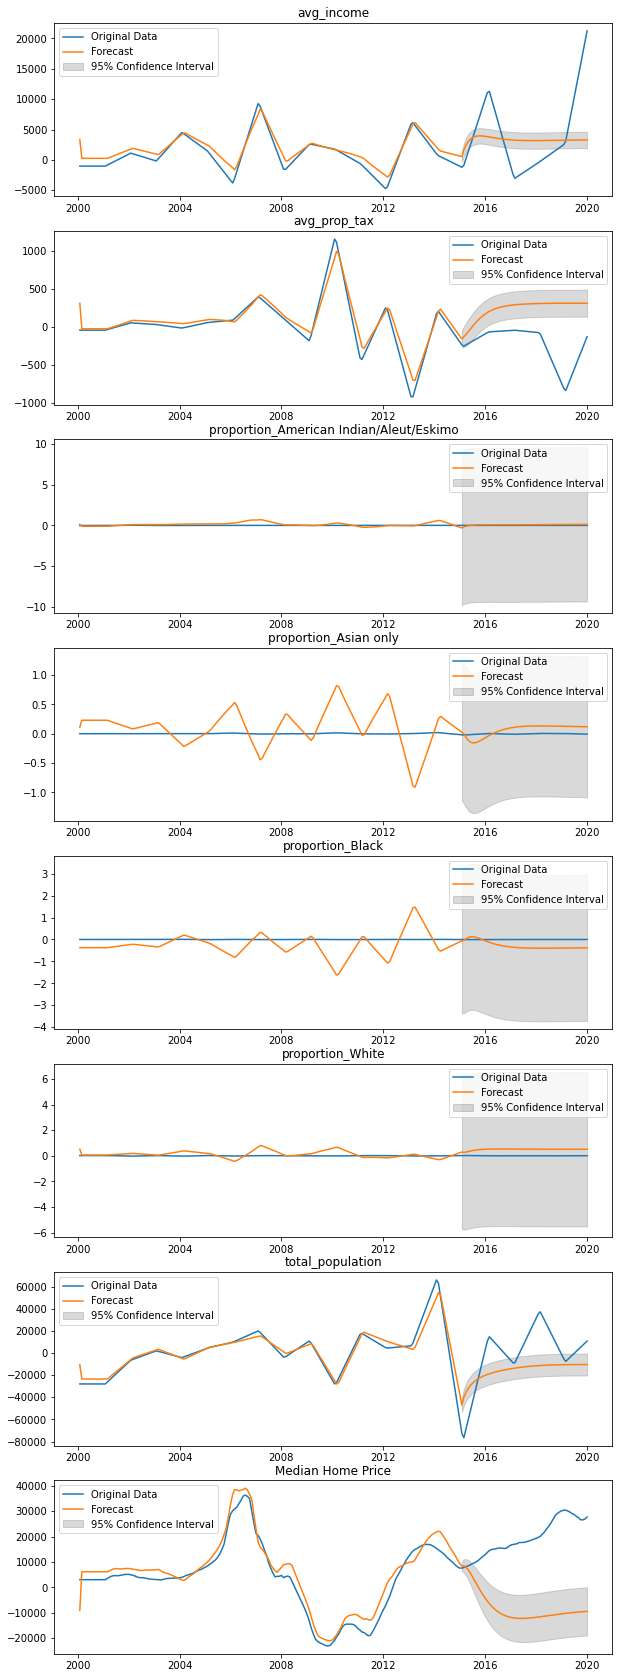

In [43]:
start = dates[0]
end = dates[-1]

columns = df.columns.tolist()

pred = VARMAX_model.predict(start, end)

# get confidence intervals
forecast_obj = VARMAX_model.get_forecast(end)
all_CI = forecast_obj.conf_int(alpha=0.05)

k = len(columns)

fig, axes = plt.subplots(k, 1, figsize=(10, 30))
ax = [ax for ax in axes.flat]

for i, col in enumerate(columns):

    ax[i].plot(df[col], label="Original Data")
    ax[i].plot(pred[col], label="Forecast")
    # ax[i].plot(all_CI[f"lower {state_name}"], 'k--', label="95% Confidence Interval")
    # ax[i].plot(all_CI[f"upper {state_name}"], 'k--')
    ax[i].fill_between(all_CI.index,
                     all_CI[f"lower {col}"],
                     all_CI[f"upper {col}"],
                     color='k', alpha=.15, label="95% Confidence Interval")
    ax[i].legend()
    ax[i].set_title(col)

# plt.tight_layout()
# plt.suptitle(f"Demographics and Housing Prices in {STATE}")

plt.show()